# Context – Drunk Smurfs
Among all international hotel guests, Smurfs are burdened with the upkeep of a singular reputation: they are (supposedly) the rowdiest bunch one can entertain, and are equally well-known for unbridled spending as for racking up extensive costs in damages to hotel infrastructure, staff, and occasionally also other guests – costs which typically cannot be recovered once the guest has sought out the safety of his (or her) homeland.
It is your job as a data scientist to screen applying Smurfs clients for an exclusive hotel in the Bahamas - yes, it's the kind of hotel you need to apply for!
# The data
At your disposal is a training set containing data about the behavior of 5000 Smurf hotel guests (train_V2.csv). This data set contains information about the profit the hotel made during their last visit (excluding damages), but also whether they caused damages during their last visit, and for what amount. These outcomes are respectively called 'outcome_profit', 'outcome_damage_inc', and 'outcome_damage_amount'. To predict them, you have access to a host of personal information: previous history of profits and damages, use of hotel facilities, socio-demographics and behavioral scores from the staff of other hotels within the hotel chains. A minor description of features is available in dictionary.csv.
You also get information on the 500 applicants for the 2024 season (score.csv). It is your job to return a list of 150 clients that offer an attractive balance between projected profit for the hotel, and anticipated damages. 
You will notice the data set contains a large number of oddities. You are expected to think yourself about what is intuitive and acceptable in terms of approach, and to provide some minor reflection on this in your technical report. 


# Possible approach
To generate a client list, you can (but don't have to) follow the next steps:
1)	prepare the data set	
* briefly survey the data
* deal with data issues:
* appropriate handle categorical data
* treat missing data
* identify outliers, and choose whether to make your analysis more robust by removing these
2)	predict the projected revenue per clients
* choose an algorithm, and train it in an optimal way
* score the 500 applicants
3)	predict which clients will cause damage
* choose an algorithm, and train it in an optimal way
* score the 500 applicants
4)	for those that will wreak havoc, predict the amount of damage they will cause
* choose an algorithm, and train it in an optimal way
* score the 500 applicants
5)	create a measure of the expected value of each applicant, and create an optimal selection of 200 guests


## 0. Loading packages and dataset

In [208]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

plt.style.use('seaborn-darkgrid')   

C:\Users\tomas\AppData\Local\Temp\ipykernel_8524\1617307288.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


In [209]:
# read in data
train = pd.read_csv('train_V2.csv')
score = pd.read_csv('score.csv')

## 1. Data exploration

1. and 2: number of features and observations

In [210]:
train.shape

(5000, 53)

In [211]:
# correlation matrix
corr_matrix = train.corr()
print(corr_matrix)
# No variables with a correlation of 1 so we don't have to remove any variables based on that


                       income_am  profit_last_am  profit_am  damage_am  \
income_am               1.000000        0.716032   0.685038   0.102339   
profit_last_am          0.716032        1.000000   0.424888   0.099840   
profit_am               0.685038        0.424888   1.000000   0.164160   
damage_am               0.102339        0.099840   0.164160   1.000000   
damage_inc              0.022713        0.046216   0.146981   0.622453   
crd_lim_rec             0.112643        0.058381   0.208033   0.288919   
credit_use_ic           0.043790        0.068244   0.114818   0.101889   
gluten_ic               0.158987        0.115330   0.167896   0.037240   
lactose_ic              0.287967        0.139112   0.404624   0.017174   
insurance_ic            0.006980        0.017561   0.058299   0.173917   
spa_ic                  0.000436        0.004509   0.038036   0.021302   
empl_ic                -0.018407       -0.008958  -0.016365   0.015352   
cab_requests            0.055035      

C:\Users\tomas\AppData\Local\Temp\ipykernel_8524\1278272464.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = train.corr()


# Check for constant variables

In [212]:
# There are no constant variables so we do not need to ommit any based on this information.
constant_columns = [col for col in train.columns if train[col].nunique() == 1]
print(constant_columns)

[]


No constant variables were found.

In [213]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
income_am,4947.0,2281.260158,8365.254507,0.000000e+00,229.000000,469.000000,1688.000000,360577.000000
profit_last_am,4947.0,696.057712,3051.119275,0.000000e+00,0.000000,52.000000,810.000000,150537.000000
profit_am,4947.0,3637.900950,5726.625669,0.000000e+00,1638.000000,1889.000000,3165.500000,100577.000000
damage_am,4954.0,145.952967,581.068095,0.000000e+00,0.000000,0.000000,0.000000,14866.000000
damage_inc,4947.0,0.352335,0.889449,0.000000e+00,0.000000,0.000000,0.000000,10.000000
crd_lim_rec,4947.0,3298.716394,4549.646039,0.000000e+00,0.000000,1500.000000,5000.000000,30000.000000
credit_use_ic,4947.0,0.041237,0.198858,0.000000e+00,0.000000,0.000000,0.000000,1.000000
gluten_ic,4947.0,0.024661,0.155107,0.000000e+00,0.000000,0.000000,0.000000,1.000000
lactose_ic,4947.0,0.094199,0.292134,0.000000e+00,0.000000,0.000000,0.000000,1.000000
insurance_ic,4947.0,0.390944,0.488011,0.000000e+00,0.000000,0.000000,1.000000,1.000000


In [214]:
train[0:500].T

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
income_am,227.0,268.0,283.0,227.0,4091.0,5108.0,13293.0,227.0,229.0,229.0,...,275.0,3655.0,227.0,3611.0,227.0,1564.0,1928.0,1010.0,1186.0,227.0
profit_last_am,0.0,16.0,23.0,0.0,1028.0,289.0,28.0,0.0,810.0,810.0,...,20.0,1441.0,0.0,1371.0,0.0,2656.5,20.0,243.0,403.0,0.0
profit_am,3201.0,1682.0,1673.0,1685.0,3425.0,6280.0,14704.0,1620.0,1620.0,1620.0,...,1630.0,2185.0,1620.0,2181.0,1620.0,5313.0,7426.0,1819.0,1771.0,1910.0
damage_am,888.0,0.0,0.0,0.0,785.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
damage_inc,6.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
crd_lim_rec,15000.0,750.0,750.0,0.0,14000.0,0.0,15000.0,0.0,0.0,0.0,...,0.0,0.0,15000.0,4000.0,0.0,0.0,0.0,7000.0,4500.0,4000.0
credit_use_ic,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
gluten_ic,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
lactose_ic,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
insurance_ic,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


3. Check for datatypes

In [215]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 53 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   income_am              4947 non-null   float64
 1   profit_last_am         4947 non-null   float64
 2   profit_am              4947 non-null   float64
 3   damage_am              4954 non-null   float64
 4   damage_inc             4947 non-null   float64
 5   crd_lim_rec            4947 non-null   float64
 6   credit_use_ic          4947 non-null   float64
 7   gluten_ic              4947 non-null   float64
 8   lactose_ic             4947 non-null   float64
 9   insurance_ic           4947 non-null   float64
 10  spa_ic                 4970 non-null   float64
 11  empl_ic                4999 non-null   float64
 12  cab_requests           4912 non-null   float64
 13  married_cd             5000 non-null   bool   
 14  bar_no                 4947 non-null   float64
 15  spor

4. and 5. Check for missing data

In [216]:
#Here we check how many missing values we have per variable.
train.isnull().sum()[train.isnull().sum() != 0]

income_am             53
profit_last_am        53
profit_am             53
damage_am             46
damage_inc            53
crd_lim_rec           53
credit_use_ic         53
gluten_ic             53
lactose_ic            53
insurance_ic          53
spa_ic                30
empl_ic                1
cab_requests          88
bar_no                53
sport_ic              53
neighbor_income      239
age                   53
marketing_permit      53
urban_ic              53
dining_ic             88
presidential          88
client_segment        53
sect_empl             53
prev_stay             53
prev_all_in_stay      53
divorce               53
fam_adult_size        53
children_no           53
tenure_mts           392
tenure_yrs           392
company_ic            53
claims_no             53
claims_am             27
nights_booked         53
gender                53
shop_am               53
shop_use              88
retired               53
gold_status           53
score1_pos          3775


In [217]:
#here we look at what percentage of the observations are not NaN per variable
(5000- train.isnull().sum()[train.isnull().sum() != 0])/5000*100

income_am           98.94
profit_last_am      98.94
profit_am           98.94
damage_am           99.08
damage_inc          98.94
crd_lim_rec         98.94
credit_use_ic       98.94
gluten_ic           98.94
lactose_ic          98.94
insurance_ic        98.94
spa_ic              99.40
empl_ic             99.98
cab_requests        98.24
bar_no              98.94
sport_ic            98.94
neighbor_income     95.22
age                 98.94
marketing_permit    98.94
urban_ic            98.94
dining_ic           98.24
presidential        98.24
client_segment      98.94
sect_empl           98.94
prev_stay           98.94
prev_all_in_stay    98.94
divorce             98.94
fam_adult_size      98.94
children_no         98.94
tenure_mts          92.16
tenure_yrs          92.16
company_ic          98.94
claims_no           98.94
claims_am           99.46
nights_booked       98.94
gender              98.94
shop_am             98.94
shop_use            98.24
retired             98.94
gold_status 

In [218]:
# Define the columns that cannot contain negative values
non_neg_cols = ['outcome_damage_inc','outcome_damage_amount','crd_lim_rec', 'credit_use_ic', 'insurance_ic', 'spa_ic', 
                'empl_ic', 'bar_no', 'sport_ic','neighbor_income','age', 'dining_ic', 
                'presidential', 'client_segment', 'sect_empl','prev_stay','prev_all_in_stay', 'fam_adult_size', 'children_no','tenure_yrs',
                'tenure_mts','company_ic', 'claims_no','claims_am', 'damage_am', 'damage_inc','nights_booked', 'shop_am', 'shop_use', 'retired',
                'profit_am','profit_last_am', 'gold_status']

mask = (train[non_neg_cols] < 0).any(axis=1)

# Drop the rows that have negative values in any of the specified columns
train = train[~mask]
train

,income_am,profit_last_am,profit_am,damage_am,damage_inc,crd_lim_rec,credit_use_ic,gluten_ic,lactose_ic,insurance_ic,...,score2_neg,score3_pos,score3_neg,score4_pos,score4_neg,score5_pos,score5_neg,outcome_profit,outcome_damage_inc,outcome_damage_amount
0,227.0,0.0,3201.0,888.0,6.0,15000.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,0.838147,0.082288,NaN,NaN,1791.66,0,0.00
1,268.0,16.0,1682.0,0.0,0.0,750.0,0.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,7.955259,1672.78,1,829.66
2,283.0,23.0,1673.0,0.0,0.0,750.0,0.0,0.0,0.0,1.0,...,0.099529,NaN,NaN,NaN,NaN,0.101955,1.743020,1001.40,0,0.00
3,227.0,0.0,1685.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,0.889793,NaN,NaN,NaN,NaN,1785.59,0,0.00
4,4091.0,1028.0,3425.0,785.0,2.0,14000.0,0.0,0.0,1.0,0.0,...,NaN,0.330503,0.766294,0.490486,0.542445,NaN,NaN,3140.74,0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,584.0,52.0,1769.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,0.745643,0.295942,0.830932,0.071366,0.313204,3.739346,2172.82,0,0.00
4996,227.0,0.0,1620.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1057.83,0,0.00
4997,239.0,5.0,2068.0,0.0,0.0,2500.0,0.0,0.0,0.0,1.0,...,0.049782,NaN,NaN,0.544873,0.331139,NaN,NaN,188.77,0,0.00
4998,1068.0,104.0,6405.0,490.0,2.0,15000.0,0.0,0.0,0.0,1.0,...,NaN,NaN,NaN,0.580246,0.388815,NaN,NaN,1863.41,0,0.00


## b) Look at the data


In [219]:
#here we look at the first 16 variables
train.iloc[:,0:16].head()

,income_am,profit_last_am,profit_am,damage_am,damage_inc,crd_lim_rec,credit_use_ic,gluten_ic,lactose_ic,insurance_ic,spa_ic,empl_ic,cab_requests,married_cd,bar_no,sport_ic
0,227.0,0.0,3201.0,888.0,6.0,15000.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,True,2.0,1.0
1,268.0,16.0,1682.0,0.0,0.0,750.0,0.0,0.0,0.0,1.0,1.0,0.0,7.0,True,3.0,0.0
2,283.0,23.0,1673.0,0.0,0.0,750.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,True,4.0,0.0
3,227.0,0.0,1685.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,True,8.0,1.0
4,4091.0,1028.0,3425.0,785.0,2.0,14000.0,0.0,0.0,1.0,0.0,1.0,0.0,4.0,False,2.0,1.0


In [220]:
#here we look at the variables starting from the 16th just to see what the data looks like
train.iloc[:,16:53].head()

,neighbor_income,age,marketing_permit,urban_ic,dining_ic,presidential,client_segment,sect_empl,prev_stay,prev_all_in_stay,...,score2_neg,score3_pos,score3_neg,score4_pos,score4_neg,score5_pos,score5_neg,outcome_profit,outcome_damage_inc,outcome_damage_amount
0,28936.0,37.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,0.838147,0.082288,NaN,NaN,1791.66,0,0.00
1,16674.0,18.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,7.955259,1672.78,1,829.66
2,32552.0,21.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.099529,NaN,NaN,NaN,NaN,0.101955,1.743020,1001.40,0,0.00
3,32252.0,37.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,NaN,NaN,0.889793,NaN,NaN,NaN,NaN,1785.59,0,0.00
4,29605.0,26.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,...,NaN,0.330503,0.766294,0.490486,0.542445,NaN,NaN,3140.74,0,0.00


## Plot the data

### Barplot

<Axes: xlabel='count', ylabel='gender'>

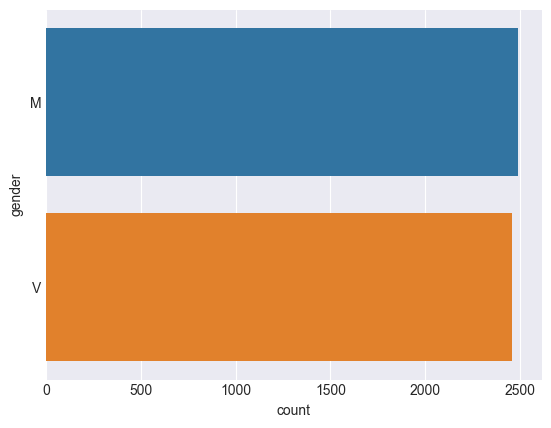

In [221]:
# Look at the amount of men and women with a bar chart
sns.countplot(y=train["gender"])

### Correlation plot

C:\Users\tomas\AppData\Local\Temp\ipykernel_8524\2512075102.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrmat = train.corr()


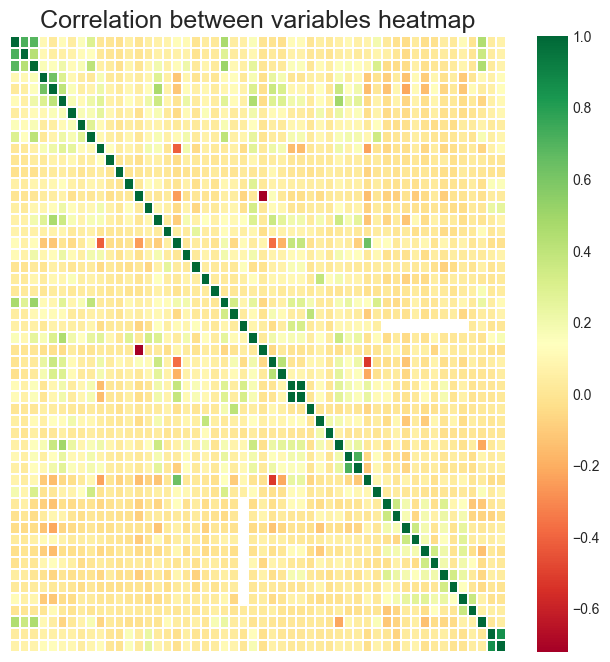

In [222]:
corrmat = train.corr()

fig, ax = plt.subplots(figsize=(8,8))

# Add title to the Heat map
title = "Correlation between variables heatmap"

# Set the font size and the distance of the title from the plot
plt.title(title,fontsize=18)
ttl = ax.title
ttl.set_position([0.5,1.05])

# Hide ticks for X & Y axis
ax.set_xticks([])
ax.set_yticks([])

# Remove the axes
ax.axis('off')

sns.heatmap(corrmat,fmt="",cmap='RdYlGn',linewidths=0.30,ax=ax)

plt.show()


In [223]:
# sns.set()
# features = train.copy()
# features = features.drop(["outcome_damage_inc"], 1)
# xvars = features.columns
# sns.pairplot(train, y_vars=['outcome_damage_inc'], x_vars=(xvars[0:5]))
# sns.pairplot(train, y_vars=['outcome_damage_inc'], x_vars=(xvars[5:10]))
# sns.pairplot(train, y_vars=['outcome_damage_inc'], x_vars=(xvars[10:15]))
# sns.pairplot(train, y_vars=['outcome_damage_inc'], x_vars=(xvars[15:20]))
# sns.pairplot(train, y_vars=['outcome_damage_inc'], x_vars=(xvars[20:25]))
# sns.pairplot(train, y_vars=['outcome_damage_inc'], x_vars=(xvars[25:30]))
# sns.pairplot(train, y_vars=['outcome_damage_inc'], x_vars=(xvars[30:35]))
# sns.pairplot(train, y_vars=['outcome_damage_inc'], x_vars=(xvars[35:40]))
# sns.pairplot(train, y_vars=['outcome_damage_inc'], x_vars=(xvars[40:45]))
# sns.pairplot(train, y_vars=['outcome_damage_inc'], x_vars=(xvars[45:50]))
# sns.pairplot(train, y_vars=['outcome_damage_inc'], x_vars=(xvars[50:53]))

# plt.show()

In [224]:
# sns.set()
# features = train.copy()
# features = features.drop(["outcome_profit"], 1)
# xvars = features.columns
# sns.pairplot(train, y_vars=['outcome_profit'], x_vars=(xvars[0:5]))
# sns.pairplot(train, y_vars=['outcome_profit'], x_vars=(xvars[5:10]))
# sns.pairplot(train, y_vars=['outcome_profit'], x_vars=(xvars[10:15]))
# sns.pairplot(train, y_vars=['outcome_profit'], x_vars=(xvars[15:20]))
# sns.pairplot(train, y_vars=['outcome_profit'], x_vars=(xvars[20:25]))
# sns.pairplot(train, y_vars=['outcome_profit'], x_vars=(xvars[25:30]))
# sns.pairplot(train, y_vars=['outcome_profit'], x_vars=(xvars[30:35]))
# sns.pairplot(train, y_vars=['outcome_profit'], x_vars=(xvars[35:40]))
# sns.pairplot(train, y_vars=['outcome_profit'], x_vars=(xvars[40:45]))
# sns.pairplot(train, y_vars=['outcome_profit'], x_vars=(xvars[45:50]))
# sns.pairplot(train, y_vars=['outcome_profit'], x_vars=(xvars[50:53]))

# plt.show()

In [225]:
# sns.set()
# features = train.copy()
# features = features.drop(["outcome_damage_amount"], 1)
# xvars = features.columns
# sns.pairplot(train, y_vars=['outcome_damage_amount'], x_vars=(xvars[0:5]))
# sns.pairplot(train, y_vars=['outcome_damage_amount'], x_vars=(xvars[5:10]))
# sns.pairplot(train, y_vars=['outcome_damage_amount'], x_vars=(xvars[10:15]))
# sns.pairplot(train, y_vars=['outcome_damage_amount'], x_vars=(xvars[15:20]))
# sns.pairplot(train, y_vars=['outcome_damage_amount'], x_vars=(xvars[20:25]))
# sns.pairplot(train, y_vars=['outcome_damage_amount'], x_vars=(xvars[25:30]))
# sns.pairplot(train, y_vars=['outcome_damage_amount'], x_vars=(xvars[30:35]))
# sns.pairplot(train, y_vars=['outcome_damage_amount'], x_vars=(xvars[35:40]))
# sns.pairplot(train, y_vars=['outcome_damage_amount'], x_vars=(xvars[40:45]))
# sns.pairplot(train, y_vars=['outcome_damage_amount'], x_vars=(xvars[45:50]))
# sns.pairplot(train, y_vars=['outcome_damage_amount'], x_vars=(xvars[50:53]))

# plt.show()

## Check for outliers

We calculate the z_scores of each data point and identify outliers as data points with a score greater than 3, here for 'outcome_damage_amount'

In [226]:
# calculate the Z-score of each data point
z_scores = np.abs((train['outcome_damage_amount'] - train['outcome_damage_amount'].mean()) / train['outcome_damage_amount'].std())

# identify outliers as data points with a Z-score greater than 3
outliers = train[z_scores > 3]

# print the number of outliers
print(len(outliers["outcome_damage_amount"]))


# from scipy import stats
# import numpy as np
# z = np.abs(stats.zscore(train))
# traintest = train[(z < 3).all(axis=1)]
# traintest

92


We calculate the z_scores of each data point and identify outliers as data points with a score greater than 3, here for 'outcome_profit'

In [227]:
# calculate the Z-score of each data point
z_scores = np.abs((train['outcome_profit'] - train['outcome_profit'].mean()) / train['outcome_profit'].std())

# identify outliers as data points with a Z-score greater than 3
outliers = train[z_scores > 3]

# print the number of outliers
print(len(outliers["outcome_profit"]))

72


We calculate the z_scores of each data point and identify outliers as data points with a score greater than 3, here for 'outcome_damage_inc'

In [228]:
# calculate the Z-score of each data point
z_scores = np.abs((train['outcome_damage_inc'] - train['outcome_damage_inc'].mean()) / train['outcome_damage_inc'].std())

# identify outliers as data points with a Z-score greater than 3
outliers = train[z_scores > 3]

# print the number of outliers
print(len(outliers["outcome_damage_inc"]))

0


In [229]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 53 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   income_am              4947 non-null   float64
 1   profit_last_am         4947 non-null   float64
 2   profit_am              4947 non-null   float64
 3   damage_am              4954 non-null   float64
 4   damage_inc             4947 non-null   float64
 5   crd_lim_rec            4947 non-null   float64
 6   credit_use_ic          4947 non-null   float64
 7   gluten_ic              4947 non-null   float64
 8   lactose_ic             4947 non-null   float64
 9   insurance_ic           4947 non-null   float64
 10  spa_ic                 4970 non-null   float64
 11  empl_ic                4999 non-null   float64
 12  cab_requests           4912 non-null   float64
 13  married_cd             5000 non-null   bool   
 14  bar_no                 4947 non-null   float64
 15  spor

## c) Look at the descriptives
1. For which features do you suspect outliers?
2. Which of these outliers seem most suspicious? Which would you certainly check if you were able to?

In [230]:
train.iloc[:,0:16].head()

,income_am,profit_last_am,profit_am,damage_am,damage_inc,crd_lim_rec,credit_use_ic,gluten_ic,lactose_ic,insurance_ic,spa_ic,empl_ic,cab_requests,married_cd,bar_no,sport_ic
0,227.0,0.0,3201.0,888.0,6.0,15000.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,True,2.0,1.0
1,268.0,16.0,1682.0,0.0,0.0,750.0,0.0,0.0,0.0,1.0,1.0,0.0,7.0,True,3.0,0.0
2,283.0,23.0,1673.0,0.0,0.0,750.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,True,4.0,0.0
3,227.0,0.0,1685.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,True,8.0,1.0
4,4091.0,1028.0,3425.0,785.0,2.0,14000.0,0.0,0.0,1.0,0.0,1.0,0.0,4.0,False,2.0,1.0


2. Convert categorical

In [231]:
# This variable is a boolean, but it is stored as an integer
train['married_cd'] = train['married_cd'].astype('int')
train.loc[:, 'married_cd']

score['married_cd'] = score['married_cd'].astype('int')

## Clean the data

1. Drop duplicates

In [232]:
train = train.drop_duplicates()
train.head()

,income_am,profit_last_am,profit_am,damage_am,damage_inc,crd_lim_rec,credit_use_ic,gluten_ic,lactose_ic,insurance_ic,...,score2_neg,score3_pos,score3_neg,score4_pos,score4_neg,score5_pos,score5_neg,outcome_profit,outcome_damage_inc,outcome_damage_amount
0,227.0,0.0,3201.0,888.0,6.0,15000.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,0.838147,0.082288,NaN,NaN,1791.66,0,0.00
1,268.0,16.0,1682.0,0.0,0.0,750.0,0.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,7.955259,1672.78,1,829.66
2,283.0,23.0,1673.0,0.0,0.0,750.0,0.0,0.0,0.0,1.0,...,0.099529,NaN,NaN,NaN,NaN,0.101955,1.743020,1001.40,0,0.00
3,227.0,0.0,1685.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,0.889793,NaN,NaN,NaN,NaN,1785.59,0,0.00
4,4091.0,1028.0,3425.0,785.0,2.0,14000.0,0.0,0.0,1.0,0.0,...,NaN,0.330503,0.766294,0.490486,0.542445,NaN,NaN,3140.74,0,0.00


2. Replace all NaN values with '-1'

In [233]:
# Replace all NaN values with a specified value (e.g., 0)
train.fillna(-1, inplace=True)
train.head()

score.fillna(-1, inplace=True)

In [234]:
na = train.isna()
columns_with_na = train.columns[na.any()].tolist() 
print(len(columns_with_na))

0


3. Drop irrelvant columns

gluten_ic and lactose_ic: The fact that a person is gluten or lactose intolerant does not indicate how likely it is for them to inflict damages or how much money they will be spending in the hotel. Maybe they will pay a tiny bit more for food without those ingredients but it shouldn't have a significant impact.

cab_requests: The hotel is very unlikely to own the cab company so wether or not they buy a lot of taxis will not influence the profit for the hotel.

marketing_permit: The choice on wether or not the marketing team may contact them will not influence how much money they will be spending nor how likely they are to inflict damages.

region: Although region could be a small factor due to cultural diferences in spending and personal traits, this could lead to discrimination of people of a certain region.

gender: Here it could also be that a cerain gender is for example more aggressive than others and thus more likely to inflict damages, but this could also lead to discrimination based on generalisations.

divorce: Being divorced or not does not impact the way you behave or spend money, definitely not if some time has passed. Maybe the first months they could be a bit more aggressive or impulsive due to their grief.

In [235]:
# drop the columns that are not needed
train = train.drop(['gluten_ic', 'lactose_ic', 'marketing_permit','divorce', 'cab_requests', 'urban_ic', 'gender', "married_cd"], axis=1) #outcome_damage_inc, outcome_damage_amount
score = score.drop(['gluten_ic', 'lactose_ic', 'marketing_permit', 'divorce', 'cab_requests', 'urban_ic', 'gender', "married_cd"], axis=1)

 I make sure all three categorical features are classified as 'object' to be able to check if they are categorical

4. Remove unwanted outliers


No unwanted outliers found

## 2. Machine Learning 


Train the different ML models to predict projected revenue


### 2.0.0 Split the data in test/train and standardize data


In [236]:
from sklearn.preprocessing import StandardScaler

X = train
X = X.drop(['outcome_damage_amount', 'outcome_damage_inc', 'outcome_profit'], axis=1)
y = train['outcome_profit']


X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
X_train, X_val, y_train, y_val = train_test_split(X_trainval,y_trainval, test_size=0.2, random_state=1234)

 Standardize

In [237]:
num_feat = X_train.select_dtypes(include=['int64', 'float64']).columns

scaler = StandardScaler()
X_train_stand = X_train.copy()
X_trainval_stand = X_trainval.copy()
X_val_stand = X_val.copy()
X_test_stand = X_test.copy()

X_train_stand[num_feat] = scaler.fit_transform(X_train[num_feat])
X_val_stand[num_feat] = scaler.transform(X_val[num_feat])
X_trainval_stand[num_feat] = scaler.transform(X_trainval[num_feat])
X_test_stand[num_feat] = scaler.transform(X_test[num_feat])

### 2.0.1 Lineair Regression

In [238]:


# Train a linear regression model
LRmodel = LinearRegression()
LRmodel.fit(X_train_stand, y_train)

LinearRegression()

In [239]:
# Evaluate the model on the testing set and validation set
print(LRmodel.score(X_train_stand, y_train))
print(LRmodel.score(X_val_stand, y_val))


0.3772670762346171
0.17380643438615606


print(LRmodel.score(X_train_stand, y_train)) = 0.3772670762346171
print(LRmodel.score(X_val_stand, y_val)) = 0.17380643438615606

In [240]:
from sklearn.model_selection import cross_val_score


# Evaluate the model using cross-validation
scores = cross_val_score(LRmodel, X_trainval_stand, y_trainval, cv=5, scoring='r2')
print('Cross-validation R^2 scores:', scores)
print('Mean cross-validation R^2 score:', scores.mean())

Cross-validation R^2 scores: [ 0.29503695  0.37003418  0.42131625  0.2815202  -0.03180097]
Mean cross-validation R^2 score: 0.26722132203092197


Cross-validation R^2 scores: [ 0.29503695  0.37003418  0.42131625  0.2815202  -0.03180097]
Mean cross-validation R^2 score: 0.26722132203092197

This indicates that the model is not a good fit for the data

In [241]:
# Predict the projected revenue for the 500 applicants

LRscore = scaler.transform(score)
LRpredictions = LRmodel.predict(LRscore)

# Sort the predictions in descending order
sorted_index = np.argsort(LRpredictions)[::-1]
LRsorted_predictions = LRpredictions[sorted_index]

print(LRsorted_predictions)

[7514.62331942 7420.88442169 6194.14438278 5470.16237386 4812.23790715
 4738.57861083 4528.23146671 4289.29301064 4246.16005226 4149.20256828
 3893.40327276 3785.6396838  3753.75636928 3670.56335494 3645.84779507
 3571.86704994 3561.73944174 3451.63762617 3419.44065549 3365.0910468
 3302.07235458 3233.70899387 3197.70477559 3189.45520685 3162.45462378
 3153.46498174 3108.32695026 3096.10358183 2985.31075288 2983.42622614
 2974.38950662 2943.59349944 2938.46595179 2928.91081566 2901.84263989
 2895.91751712 2891.31498126 2890.47571757 2867.01798409 2774.93305178
 2737.76926347 2685.50921111 2678.63884783 2635.46227634 2633.57431773
 2617.28559518 2603.606714   2598.57192428 2596.97475475 2594.21223037
 2570.14441022 2564.73240243 2552.22920887 2524.94229781 2521.98106289
 2517.25734698 2502.31881794 2499.22288016 2463.85963418 2452.84825086
 2435.13689239 2432.75237703 2426.68920067 2425.74682721 2424.64714637
 2423.4429953  2400.79542556 2400.30828234 2395.99321024 2390.56032474
 2387.4

c:\Users\tomas\.virtualenvs\project_venv-gMVSJCd2\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


### 2.0.2 KNN 

In [242]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor


# Create a KNeighborsRegressor object
KNNmodel = KNeighborsRegressor()

# Define the grid of hyperparameters to search over
param_grid = {'n_neighbors': range(1, 101)}

# Perform a grid search with cross-validation
grid_search = GridSearchCV(KNNmodel, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train_stand, y_train)

# Print the best hyperparameter value and score
print("Best n_neighbors:", grid_search.best_params_['n_neighbors'])
print("Best R2 score:", grid_search.best_score_)


Best n_neighbors: 8
Best R2 score: 0.24255555335173443


In [243]:
# Heeft een score van 0.025000182087153267
from sklearn.metrics import r2_score

# Train a linear regression model
KNNmodel = KNeighborsRegressor(n_neighbors=8)
KNNmodel.fit(X_train_stand, y_train)

KNeighborsRegressor(n_neighbors=8)

In [244]:
# Make predictions on the testing set
KNNy_pred = KNNmodel.predict(X_test_stand)

# Evaluate the model using r-squared score
r2 = r2_score(y_test, KNNy_pred)
print('R-squared score:', r2)

y_predval = KNNmodel.predict(X_val_stand)

r2val = r2_score(y_val, y_predval)
print("R2 score validation set:", r2val)

R-squared score: 0.2300739800278524
R2 score validation set: 0.015405506742735664


In [245]:
# Predict the projected revenue for the 500 applicants
KNNscore = scaler.transform(score)
KNNpredictions = KNNmodel.predict(KNNscore)

# Sort the predictions in descending order
KNNsorted_index = np.argsort(KNNpredictions)[::-1]
KNNsorted_predictions = KNNpredictions[KNNsorted_index]

print(KNNsorted_predictions)

[7361.02    6608.05875 5130.36625 4727.67625 4584.915   4470.89375
 4323.26625 4322.63    4321.29625 4313.93125 4192.25875 3933.57625
 3794.3575  3636.67625 3630.21    3120.36    3111.325   3076.9375
 2910.34375 2860.07375 2825.20125 2820.415   2790.97125 2789.75875
 2759.33    2743.84375 2732.96125 2711.93125 2711.0525  2676.11375
 2672.54875 2613.44125 2611.035   2597.1175  2581.39875 2579.73
 2543.8875  2542.81    2542.27125 2527.49125 2504.5275  2502.9975
 2491.8525  2482.33375 2480.08125 2466.1575  2457.56625 2455.23125
 2439.8575  2437.515   2433.2675  2431.30375 2429.3875  2416.985
 2397.99375 2390.255   2369.9     2369.57125 2366.915   2362.18375
 2344.8     2334.88625 2333.33625 2331.76125 2330.75    2321.06375
 2305.18625 2302.13625 2292.05625 2288.68125 2282.2075  2281.18375
 2278.75375 2277.8125  2261.15875 2259.465   2257.23625 2255.7225
 2255.63125 2253.1275  2242.69375 2241.5925  2235.7575  2234.8875
 2233.00375 2228.39    2207.5425  2204.31    2202.67125 2192.36625
 218

c:\Users\tomas\.virtualenvs\project_venv-gMVSJCd2\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


Plot of the Actual outcomes and predicted outcomes: KNN

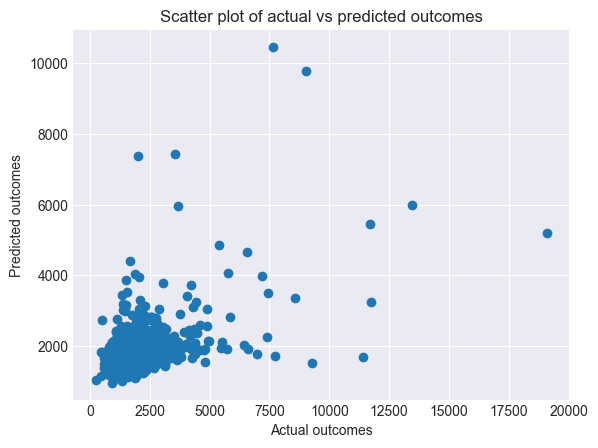

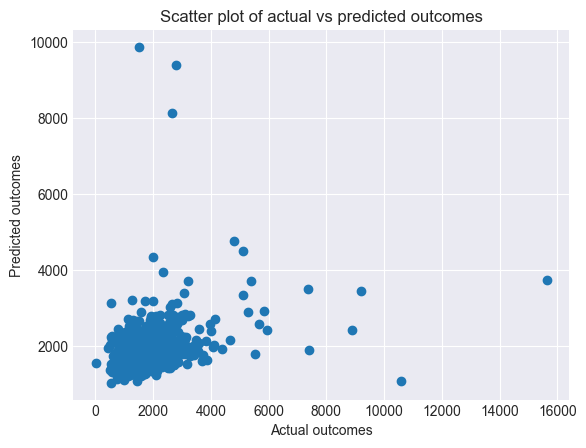

In [246]:
# plot the predicted outcomes against the actual outcomes in the testing set
plt.scatter(y_test, KNNy_pred)
plt.xlabel('Actual outcomes')
plt.ylabel('Predicted outcomes')
plt.title('Scatter plot of actual vs predicted outcomes')
plt.show()


# plot the predicted outcomes against the actual outcomes in the testing set
plt.scatter(y_val, y_predval)
plt.xlabel('Actual outcomes')
plt.ylabel('Predicted outcomes')
plt.title('Scatter plot of actual vs predicted outcomes')
plt.show()


### 2.0.3 Decision Tree

In [247]:
from sklearn.tree import DecisionTreeRegressor
# Create a decision tree regressor object
dt_regressor = DecisionTreeRegressor(random_state=0)

# Fit the regressor with the training data
dt_regressor.fit(X_train_stand, y_train)

DecisionTreeRegressor(random_state=0)

In [248]:
# Predict the revenue on the testing data
y_pred_dt = dt_regressor.predict(X_test_stand)

# Compute R^2 score on the testing data
r2_score_dt = dt_regressor.score(X_test_stand, y_test)
print("R^2 Score (Decision Tree Regression): ", r2_score_dt)


R^2 Score (Decision Tree Regression):  0.5686868385314154


In [249]:
# Predict the projected revenue for the 500 applicants

DTscore = scaler.transform(score)
DTpredictions = dt_regressor.predict(DTscore)

# Sort the predictions in descending order
DTsorted_index = np.argsort(DTpredictions)[::-1]
DTsorted_predictions = DTpredictions[DTsorted_index]

print(DTsorted_predictions)

[13529.43   11451.15   10128.6     8140.01    7803.61    7266.59
  6820.67    6715.78    5208.93    4938.65    4559.28    4353.15
  4318.76    4318.76    4318.76    4281.27    4279.12    4044.41
  3945.25    3901.57    3873.31    3863.28    3855.11    3777.81
  3775.76    3751.56    3740.37    3630.04    3592.16    3544.87
  3536.54    3512.36    3477.51    3390.65    3388.63    3388.63
  3381.4     3300.25    3296.23    3292.6     3292.6     3168.4
  3134.67    3093.36    3061.69    3045.95    3045.95    3018.99
  3018.99    3018.99    2995.26    2995.26    2974.      2974.
  2974.      2974.      2972.7025  2926.4     2901.69    2897.1
  2891.8     2865.04    2850.73    2843.44    2836.8     2793.45
  2784.23    2758.17    2737.3     2731.25    2723.64    2713.05
  2713.02    2709.24    2697.974   2681.47    2676.17    2675.32
  2675.32    2667.79    2647.58    2645.93    2644.64    2643.48
  2643.48    2631.4     2625.12    2617.98    2617.46    2613.79
  2610.48    2607.29    2596.

c:\Users\tomas\.virtualenvs\project_venv-gMVSJCd2\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


Plot of the Actual outcomes and predicted outcomes: Decision Tree

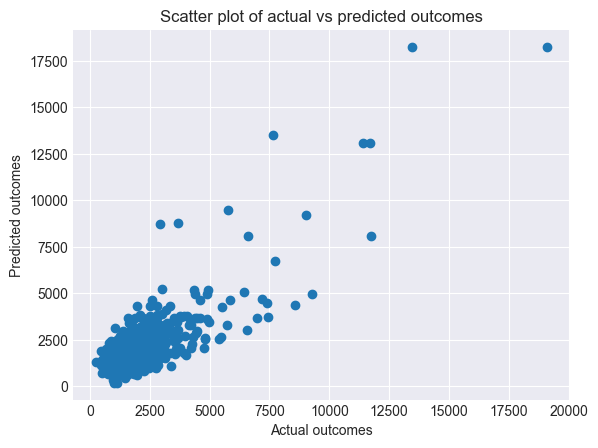

In [250]:
# plot the predicted outcomes against the actual outcomes in the testing set
plt.scatter(y_test, y_pred_dt)
plt.xlabel('Actual outcomes')
plt.ylabel('Predicted outcomes')
plt.title('Scatter plot of actual vs predicted outcomes')
plt.show()

### 2.0.4 Random Forest 

In [251]:
# This algorithm has a score of 0.7581997911409797
from sklearn.ensemble import RandomForestRegressor

# Instantiate the model
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model to the training data
rf.fit(X_train_stand, y_train)


RandomForestRegressor(random_state=42)

In [252]:
# Predict on the test data
RFy_pred = rf.predict(X_test_stand)

# Evaluate the model using r2 score
RFr2 = r2_score(y_test, RFy_pred)
print("r2 score on test set:", RFr2)

# Predict on the validation data
RFy_predval = rf.predict(X_val_stand)

# Evaluate the model using r2 score
RFr2 = r2_score(y_val, RFy_predval)
print("r2 score on validation set:", RFr2)

r2 score on test set: 0.7779437379498056
r2 score on validation set: 0.6878879761065633


In [253]:
# Predict the projected revenue for the 500 applicants
RFscore = scaler.transform(score)
RFpredictions = rf.predict(RFscore)

# Sort the predictions in descending order
RFsorted_index = np.argsort(RFpredictions)[::-1]
RFsorted_predictions = RFpredictions[RFsorted_index]

c:\Users\tomas\.virtualenvs\project_venv-gMVSJCd2\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Plot of the Actual outcomes and predicted outcomes: Random Forrest

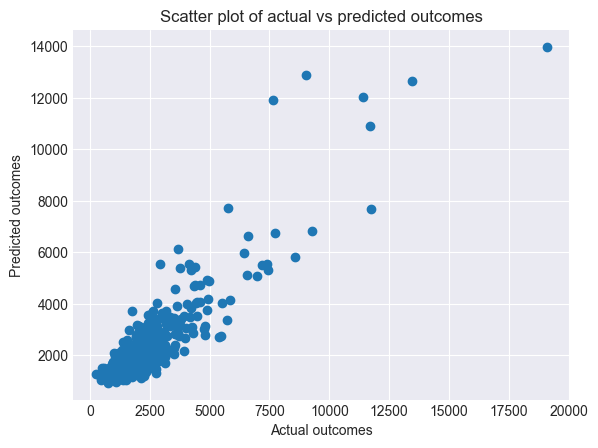

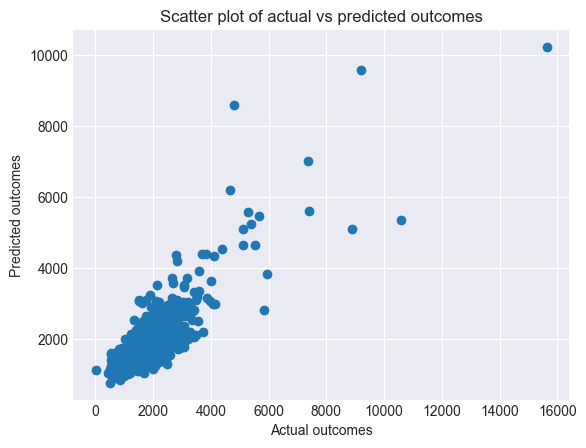

In [254]:
plt.scatter(y_test, RFy_pred)
plt.xlabel('Actual outcomes')
plt.ylabel('Predicted outcomes')
plt.title('Scatter plot of actual vs predicted outcomes')
plt.show()

plt.scatter(y_val, RFy_predval)
plt.xlabel('Actual outcomes')
plt.ylabel('Predicted outcomes')
plt.title('Scatter plot of actual vs predicted outcomes')
plt.show()

### 2.0.5 Gradient Boosting

In [255]:
# Dit algoritme heeft een score van 0.771681378659433
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score

# Instantiate the model
GBmodel = GradientBoostingRegressor()

# Fit the model on the training data
GBmodel.fit(X_train_stand, y_train)

GradientBoostingRegressor()

In [256]:
# Make predictions on the testing data
GBy_pred = GBmodel.predict(X_test_stand)

# Calculate the R-squared score on the testing data
GBr2 = r2_score(y_test, GBy_pred)
print("R-squared score on testing data:", GBr2)

GBy_predval = GBmodel.predict(X_val_stand)
GBr2val = r2_score(y_val, GBy_predval)
print("R2 score for validation set:", GBr2val)

R-squared score on testing data: 0.7962017564114647
R2 score for validation set: 0.7279465932749398


In [257]:
# Predict the projected revenue for the 500 applicants

GBscore = scaler.transform(score)
GBpredictions = GBmodel.predict(GBscore)

# Sort the predictions in descending order
GBsorted_index = np.argsort(GBpredictions)[::-1]
GBsorted_predictions = GBpredictions[GBsorted_index]

print(GBsorted_predictions)

[16536.55081015 12402.95035116 11239.50788834  9872.37447822
  8835.75760684  7430.86242188  6748.63614929  6311.98419545
  4928.63342124  4613.5637078   4317.91340869  4142.84099054
  3873.28517931  3659.84968942  3469.63194884  3425.70321567
  3400.69227791  3397.1824784   3386.3448928   3380.25114066
  3374.77776221  3307.20901143  3193.3618407   3167.18247091
  3138.56400042  3135.91474526  3135.77068947  3133.42547795
  3126.61818305  3124.98725878  3090.44917834  3064.11179039
  3033.80548193  3033.77947944  3028.25185267  3025.39371265
  3022.49992371  2997.78986711  2949.46191132  2947.36644398
  2934.15874352  2929.97402873  2888.85243789  2826.58459397
  2814.18745216  2797.45533916  2781.64858041  2688.88982558
  2688.86668832  2666.20140822  2657.69223098  2655.8483605
  2649.85994429  2640.73402398  2620.95936488  2612.97841807
  2582.190429    2582.190429    2569.49393129  2552.84534038
  2550.31376597  2535.89610899  2519.9351403   2501.83030003
  2487.63917301  2477.459

c:\Users\tomas\.virtualenvs\project_venv-gMVSJCd2\Lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


Plot of the Actual outcomes and predicted outcomes: Gradient Boosting

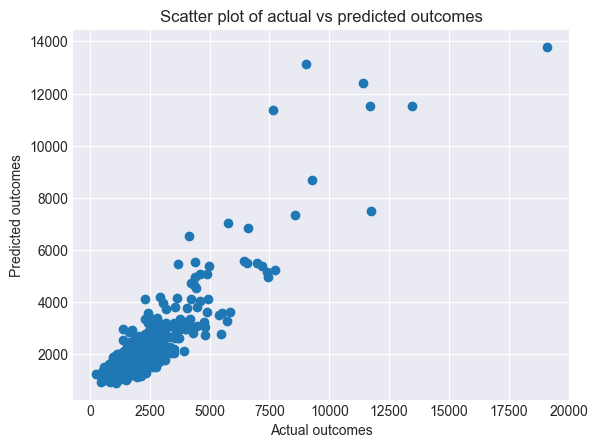

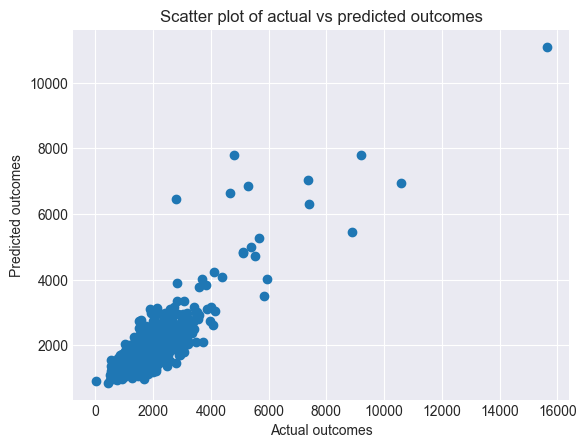

In [258]:
plt.scatter(y_test, GBy_pred)
plt.xlabel('Actual outcomes')
plt.ylabel('Predicted outcomes')
plt.title('Scatter plot of actual vs predicted outcomes')
plt.show()


plt.scatter(y_val, GBy_predval)
plt.xlabel('Actual outcomes')
plt.ylabel('Predicted outcomes')
plt.title('Scatter plot of actual vs predicted outcomes')
plt.show()


### Rate the models

In [259]:
# LRmodel = LinearRegression()
# KNNmodel = KNeighborsRegressor(n_neighbors=50)
# dt_regressor = DecisionTreeRegressor(random_state=0)
# rf = RandomForestRegressor(n_estimators=100, random_state=42)
# GBmodel = GradientBoostingRegressor()



# Fit each model on the training set
LRmodel.fit(X_train_stand, y_train)
KNNmodel.fit(X_train_stand, y_train)
dt_regressor.fit(X_train_stand, y_train)
rf.fit(X_train_stand,y_train)
GBmodel.fit(X_train_stand, y_train)

# Predict the outcome variable for the validation set using each model
LRy_pred = LRmodel.predict(X_val_stand)
KNNy_pred = KNNmodel.predict(X_val_stand)
dty_pred = dt_regressor.predict(X_val_stand)
rf_pred = rf.predict(X_val_stand)
GB_pred = GBmodel.predict(X_val_stand)

# Evaluate the performance of each model on the validation set
LRr2 = r2_score(y_val, LRy_pred)
KNNr2 = r2_score(y_val, KNNy_pred)
dtr2 = r2_score(y_val, dty_pred)
rfr2 = r2_score(y_val, rf_pred)
GBr2 = r2_score(y_val, GB_pred)

print("Linear Regression R-squared on validation set:", LRr2)
print("KNN Regression R-squared on validation set:", KNNr2)
print("Decision Tree Regression R-squared on validation set:", dtr2)
print("Random forest R-squared on validation set:", rfr2)
print("Gradient boosting R-squared on validation set: ", GBr2)


Linear Regression R-squared on validation set: 0.17380643438615606
KNN Regression R-squared on validation set: 0.015405506742735664
Decision Tree Regression R-squared on validation set: 0.41096192481159755
Random forest R-squared on validation set: 0.6878879761065633
Gradient boosting R-squared on validation set:  0.7351503630247291


was: Linear Regression R-squared on validation set: 0.17380643438615606
KNN Regression R-squared on validation set: -0.07107551539386181
Decision Tree Regression R-squared on validation set: 0.41096192481159755
Random forest R-squared on validation set: 0.6878879761065633
Gradient boosting R-squared on validation set:  0.7346863177996616

In [260]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import cross_val_score

# # Create a list of models
# models = [LRmodel, KNNmodel, dt_regressor, rf, GBmodel]

# # Create a list of model names
# model_names = ['Linear Regression', 'KNN Regression', 'Decision Tree Regression', 'Random Forest', 'Gradient Boosting']

# # Create a list of dictionaries containing the hyperparameter grids to search over for each model
# param_grids = [
#     {},
#     {'n_neighbors': [5, 10, 20, 50]},
#     {'max_depth': [1, 2, 3, 4, 5]},
#     {'n_estimators': [50, 100, 150]},
#     {'n_estimators': [50, 100, 150], 'max_depth': [1, 2, 3, 4, 5]}
# ]

# # Create an empty list to store the validation scores for each model
# scores = []

# # Loop over each model and corresponding hyperparameter grid
# for model, model_name, param_grid in zip(models, model_names, param_grids):
#     # Perform a grid search using 5-fold cross-validation
#     grid_search = GridSearchCV(model, param_grid, cv=5, scoring='r2')
#     grid_search.fit(X_trainval_stand, y_trainval)
    
#     # Print the best hyperparameters and corresponding score
#     print(model_name)
#     print('Best hyperparameters:', grid_search.best_params_)
#     print('Best score:', grid_search.best_score_)
    
#     # Store the validation score for the best hyperparameters
#     score = cross_val_score(grid_search.best_estimator_, X_val_stand, y_val, cv=5, scoring='r2').mean()
#     scores.append(score)
#     print('Validation score:', score)
#     print('-' * 80)

# # Find the index of the best model based on the validation scores
# best_model_idx = np.argmax(scores)

# # Print the best model and corresponding validation score
# print('Best model:', model_names[best_model_idx])
# print('Validation score:', scores[best_model_idx])


# 3. Conclusion Rating ML Algorithms

Linear Regression
Best hyperparameters: {}
Best score: 0.26722132203092197
Validation score: 0.002271535530945901

KNN Regression
Best hyperparameters: {'n_neighbors': 20}
Best score: 0.1864932411723101
Validation score: 0.12424919807163023

Decision Tree Regression
Best hyperparameters: {'max_depth': 5}
Best score: 0.5299749641751135
Validation score: 0.3453239666410732

Random Forest
Best hyperparameters: {'n_estimators': 150}
Best score: 0.7117468481471221
Validation score: 0.5028843717269464

Gradient Boosting
Best hyperparameters: {'max_depth': 3, 'n_estimators': 150}
Best score: 0.7453953411092687
Validation score: 0.6030986010969092

Best model: Gradient Boosting
Validation score: 0.6030986010969092

# 2.1 Damages

Score the 500 applicants

### Split data in test/train and standardize

In [261]:
from sklearn.preprocessing import StandardScaler

X = train
X = X.drop(['outcome_damage_amount', 'outcome_damage_inc', 'outcome_profit'], axis=1)
y = train['outcome_damage_inc']


X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
X_train, X_val, y_train, y_val = train_test_split(X_trainval,y_trainval, test_size=0.2, random_state=1234)

num_feat = X_train.select_dtypes(include=['int64', 'float64']).columns

scaler = StandardScaler()
X_train_stand = X_train.copy()
X_trainval_stand = X_trainval.copy()
X_val_stand = X_val.copy()
X_test_stand = X_test.copy()

X_train_stand[num_feat] = scaler.fit_transform(X_train[num_feat])
X_val_stand[num_feat] = scaler.transform(X_val[num_feat])
X_trainval_stand[num_feat] = scaler.transform(X_trainval[num_feat])
X_test_stand[num_feat] = scaler.transform(X_test[num_feat])

### 2.1.1 Decision Tree

In [262]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

# fit decision tree regressor with cross-validation
depth = np.arange(1, 50)
cv_scores = []
sd_scores = []
for d in depth:
    dec_tree = DecisionTreeRegressor(random_state=0, max_depth=d)
    scores = cross_val_score(dec_tree, X_train_stand, y_train, cv=5)
    cv_scores.append(scores.mean())
    sd_scores.append(np.sqrt(scores.var())/np.sqrt(5))

# fit decision tree regressor to entire training set
dec_tree.fit(X_train_stand, y_train)

# Standardize numerical features for new applicants
num_feat = [feat for feat in num_feat if feat in score.columns] # remove non-existent features
new_applicants_stand = score.copy()
new_applicants_stand[num_feat] = scaler.transform(score[num_feat])


# Predict damages for new applicants using the trained decision tree regressor
damages_pred = dec_tree.predict(new_applicants_stand)
print(np.where(damages_pred > 0.5, 1, 0))

# Only keep the applicants who will cause damage to calculate the damage amount
applicants_who_will_cause_damage = new_applicants_stand[damages_pred > 0]
applicants_who_will_cause_damage



[0 0 0 0 0 1 0 1 1 0 1 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0
 0 0 1 0 0 0 1 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 1 1 1 0 0 1 0 1 0 0 0 0 0 1 0
 1 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1
 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 0 0 0 0 1 1 0 1 0 1 1 0 0 0
 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 0 0 0 1 0 1 0 0 1 0 1 0 0
 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 1 0 0 0 1 0 0 1 0 0 1 0 0 1 0 0 0 1 0 0 1 0
 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 0 0 1 0 0 0 1 1 1 1 0
 0 1 0 1 0 1 1 0 0 0 1 0 1 1 0 0 0 1 1 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0
 0 1 0 0 0 1 0 0 1 0 1 1 1 0 0 1 1 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0
 0 0 1 1 0 1 0 1 0 0 0 0 0 1 0 0 1 1 0 0 0 1 0 0 1 1 0 0 1 1 0 0 1 0 1 1 0
 0 0 0 0 0 0 1 0 0 1 0 1 

,income_am,profit_last_am,profit_am,damage_am,damage_inc,crd_lim_rec,credit_use_ic,insurance_ic,spa_ic,empl_ic,...,score1_pos,score1_neg,score2_pos,score2_neg,score3_pos,score3_neg,score4_pos,score4_neg,score5_pos,score5_neg
5,-0.228766,-0.207867,-0.348551,-0.246699,-0.388613,-0.719412,-0.138384,1.225543,1.220741,-0.157022,...,-0.542941,-0.563286,-0.551268,-0.580259,-0.558447,-0.593317,-0.550761,-0.579930,-0.551950,0.332770
7,0.020473,0.039424,-0.246715,-0.246699,-0.388613,-0.719412,-0.138384,-0.752136,-0.774341,-0.157022,...,-0.542941,-0.563286,-0.551268,-0.580259,1.836277,1.731613,-0.550761,-0.579930,1.120206,1.340809
8,0.424801,0.366394,0.930012,3.594028,1.781653,1.484265,-0.138384,1.225543,1.220741,-0.157022,...,-0.542941,-0.563286,-0.551268,-0.580259,1.830378,1.280267,-0.550761,-0.579930,-0.551950,-0.553399
10,-0.223178,-0.201606,-0.290458,-0.246699,-0.388613,-0.388861,-0.138384,-0.752136,-0.774341,-0.157022,...,-0.542941,-0.563286,-0.551268,-0.580259,2.265037,1.958805,-0.550761,-0.579930,2.471695,1.420173
13,-0.228766,-0.207867,-0.348378,-0.246699,-0.388613,-0.719412,-0.138384,1.225543,1.220741,-0.157022,...,-0.542941,-0.563286,-0.551268,-0.580259,-0.558447,-0.593317,-0.550761,-0.579930,-0.551950,-0.553399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,-0.108786,0.218845,-0.110128,1.063725,2.866787,2.145368,-0.138384,-0.752136,1.220741,-0.157022,...,-0.542941,-0.563286,1.233034,1.701892,-0.558447,-0.593317,-0.550761,-0.579930,-0.551950,-0.553399
487,-0.223284,-0.207867,-0.303598,0.299859,2.866787,-0.168493,-0.138384,1.225543,-0.774341,-0.157022,...,-0.542941,-0.563286,-0.551268,-0.580259,1.076851,1.082894,-0.550761,-0.579930,-0.551950,-0.553399
490,0.366287,1.321693,0.300672,1.019276,0.696520,1.263897,-0.138384,-0.752136,-0.774341,-0.157022,...,-0.542941,-0.563286,-0.551268,-0.580259,2.048840,2.200454,1.080838,1.284259,-0.551950,-0.553399
492,0.317788,-0.197907,0.578515,-0.246699,-0.388613,1.704633,-0.138384,-0.752136,1.220741,-0.157022,...,-0.542941,-0.563286,-0.551268,-0.580259,-0.558447,-0.593317,-0.550761,-0.579930,-0.551950,-0.553399


### 2.1.3 Gradient Boosting

In [263]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

# fit decision tree regressor with cross-validation
depth = np.arange(1, 50)
cv_scores = []
sd_scores = []
for d in depth:
    dec_tree = DecisionTreeRegressor(random_state=0, max_depth=d)
    scores = cross_val_score(dec_tree, X_train_stand, y_train, cv=5)
    cv_scores.append(scores.mean())
    sd_scores.append(np.sqrt(scores.var())/np.sqrt(5))

# fit decision tree regressor to entire training set
dec_tree.fit(X_train_stand, y_train)

# Standardize numerical features for new applicants
num_feat = [feat for feat in num_feat if feat in score.columns] # remove non-existent features
new_applicants_stand = score.copy()
new_applicants_stand[num_feat] = scaler.transform(score[num_feat])

# Predict damages for new applicants using the trained decision tree regressor
damages_pred = dec_tree.predict(new_applicants_stand)
print(np.where(damages_pred > 0.5, 1, 0))

# Only keep the applicants who will cause damage to calculate the damage amount
applicants_who_will_cause_damage = new_applicants_stand[damages_pred > 0]
applicants_who_will_cause_damage


[0 0 0 0 0 1 0 1 1 0 1 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0
 0 0 1 0 0 0 1 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 1 1 1 0 0 1 0 1 0 0 0 0 0 1 0
 1 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1
 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 0 0 0 0 1 1 0 1 0 1 1 0 0 0
 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 0 0 0 1 0 1 0 0 1 0 1 0 0
 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 1 0 0 0 1 0 0 1 0 0 1 0 0 1 0 0 0 1 0 0 1 0
 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 0 0 1 0 0 0 1 1 1 1 0
 0 1 0 1 0 1 1 0 0 0 1 0 1 1 0 0 0 1 1 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0
 0 1 0 0 0 1 0 0 1 0 1 1 1 0 0 1 1 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1
 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0
 0 0 1 1 0 1 0 1 0 0 0 0 0 1 0 0 1 1 0 0 0 1 0 0 1 1 0 0 1 1 0 0 1 0 1 1 0
 0 0 0 0 0 0 1 0 0 1 0 1 

,income_am,profit_last_am,profit_am,damage_am,damage_inc,crd_lim_rec,credit_use_ic,insurance_ic,spa_ic,empl_ic,...,score1_pos,score1_neg,score2_pos,score2_neg,score3_pos,score3_neg,score4_pos,score4_neg,score5_pos,score5_neg
5,-0.228766,-0.207867,-0.348551,-0.246699,-0.388613,-0.719412,-0.138384,1.225543,1.220741,-0.157022,...,-0.542941,-0.563286,-0.551268,-0.580259,-0.558447,-0.593317,-0.550761,-0.579930,-0.551950,0.332770
7,0.020473,0.039424,-0.246715,-0.246699,-0.388613,-0.719412,-0.138384,-0.752136,-0.774341,-0.157022,...,-0.542941,-0.563286,-0.551268,-0.580259,1.836277,1.731613,-0.550761,-0.579930,1.120206,1.340809
8,0.424801,0.366394,0.930012,3.594028,1.781653,1.484265,-0.138384,1.225543,1.220741,-0.157022,...,-0.542941,-0.563286,-0.551268,-0.580259,1.830378,1.280267,-0.550761,-0.579930,-0.551950,-0.553399
10,-0.223178,-0.201606,-0.290458,-0.246699,-0.388613,-0.388861,-0.138384,-0.752136,-0.774341,-0.157022,...,-0.542941,-0.563286,-0.551268,-0.580259,2.265037,1.958805,-0.550761,-0.579930,2.471695,1.420173
13,-0.228766,-0.207867,-0.348378,-0.246699,-0.388613,-0.719412,-0.138384,1.225543,1.220741,-0.157022,...,-0.542941,-0.563286,-0.551268,-0.580259,-0.558447,-0.593317,-0.550761,-0.579930,-0.551950,-0.553399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,-0.108786,0.218845,-0.110128,1.063725,2.866787,2.145368,-0.138384,-0.752136,1.220741,-0.157022,...,-0.542941,-0.563286,1.233034,1.701892,-0.558447,-0.593317,-0.550761,-0.579930,-0.551950,-0.553399
487,-0.223284,-0.207867,-0.303598,0.299859,2.866787,-0.168493,-0.138384,1.225543,-0.774341,-0.157022,...,-0.542941,-0.563286,-0.551268,-0.580259,1.076851,1.082894,-0.550761,-0.579930,-0.551950,-0.553399
490,0.366287,1.321693,0.300672,1.019276,0.696520,1.263897,-0.138384,-0.752136,-0.774341,-0.157022,...,-0.542941,-0.563286,-0.551268,-0.580259,2.048840,2.200454,1.080838,1.284259,-0.551950,-0.553399
492,0.317788,-0.197907,0.578515,-0.246699,-0.388613,1.704633,-0.138384,-0.752136,1.220741,-0.157022,...,-0.542941,-0.563286,-0.551268,-0.580259,-0.558447,-0.593317,-0.550761,-0.579930,-0.551950,-0.553399


### 2.1.4 KNN

In [264]:
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score

# fit KNN regressor with cross-validation
k_values = np.arange(1, 50)
cv_scores = []
sd_scores = []
for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k)
    scores = cross_val_score(knn, X_train_stand, y_train, cv=5)
    cv_scores.append(scores.mean())
    sd_scores.append(np.sqrt(scores.var())/np.sqrt(5))

# fit KNN regressor to entire training set
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train_stand, y_train)

# Standardize numerical features for new applicants
num_feat = [feat for feat in num_feat if feat in score.columns] # remove non-existent features
new_applicants_stand = score.copy()
new_applicants_stand[num_feat] = scaler.transform(score[num_feat])

# Predict damages for new applicants using the trained KNN regressor
damages_pred = knn.predict(new_applicants_stand)
print(np.where(damages_pred > 0.5, 1, 0))

# Only keep the applicants who will cause damage to calculate the damage amount
applicants_who_will_cause_damage = new_applicants_stand[damages_pred > 0]
applicants_who_will_cause_damage


[0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 1 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 1 0 0 0 1 0
 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

,income_am,profit_last_am,profit_am,damage_am,damage_inc,crd_lim_rec,credit_use_ic,insurance_ic,spa_ic,empl_ic,...,score1_pos,score1_neg,score2_pos,score2_neg,score3_pos,score3_neg,score4_pos,score4_neg,score5_pos,score5_neg
0,0.344041,1.021473,0.865176,-0.246699,-0.388613,1.043530,-0.138384,-0.752136,-0.774341,-0.157022,...,1.803152,1.540474,1.626079,2.044536,-0.558447,-0.593317,-0.550761,-0.57993,-0.551950,-0.553399
1,0.167971,-0.205306,-0.032152,-0.246699,-0.388613,2.035185,-0.138384,1.225543,-0.774341,-0.157022,...,-0.542941,-0.563286,-0.551268,-0.580259,-0.558447,-0.593317,-0.550761,-0.57993,-0.551950,-0.553399
4,-0.152961,-0.144692,-0.276626,-0.246699,-0.388613,-0.719412,-0.138384,-0.752136,-0.774341,-0.157022,...,-0.542941,-0.563286,-0.551268,-0.580259,-0.558447,-0.593317,-0.550761,-0.57993,-0.551950,-0.553399
5,-0.228766,-0.207867,-0.348551,-0.246699,-0.388613,-0.719412,-0.138384,1.225543,1.220741,-0.157022,...,-0.542941,-0.563286,-0.551268,-0.580259,-0.558447,-0.593317,-0.550761,-0.57993,-0.551950,0.332770
6,-0.109418,-0.074973,-0.214557,-0.246699,-0.388613,2.035185,-0.138384,1.225543,-0.774341,-0.157022,...,-0.542941,-0.563286,-0.551268,-0.580259,-0.558447,-0.593317,-0.550761,-0.57993,-0.551950,-0.553399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493,-0.209789,0.027045,-0.343191,-0.246699,-0.388613,-0.719412,-0.138384,-0.752136,1.220741,-0.157022,...,1.443691,1.126140,-0.551268,-0.580259,1.162464,0.938385,-0.550761,-0.57993,-0.551950,-0.553399
494,-0.173099,-0.174288,-0.309304,-0.246699,-0.388613,-0.719412,-0.138384,-0.752136,-0.774341,-0.157022,...,1.231358,1.130355,-0.551268,-0.580259,-0.558447,-0.593317,-0.550761,-0.57993,-0.551950,-0.553399
495,-0.166246,-0.146400,0.718907,1.569127,2.866787,1.263897,-0.138384,1.225543,1.220741,-0.157022,...,1.450602,1.938195,-0.551268,-0.580259,2.075424,2.214026,-0.550761,-0.57993,1.370393,2.178623
496,0.389587,0.389729,-0.086268,-0.246699,-0.388613,-0.719412,-0.138384,-0.752136,1.220741,-0.157022,...,-0.542941,-0.563286,1.620327,1.902719,-0.558447,-0.593317,-0.550761,-0.57993,-0.551950,-0.553399


## 2.1.5 Lineair Regression

In [265]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

# fit linear regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train_stand, y_train)

# Standardize numerical features for new applicants
new_applicants_stand = score.copy()
new_applicants_stand[num_feat] = scaler.transform(score[num_feat])

# Predict damages for new applicants using the trained linear regression model
damages_pred = lin_reg.predict(new_applicants_stand)
print(np.where(damages_pred > 0.5, 1, 0))

# Only keep the applicants who will cause damage to calculate the damage amount
applicants_who_will_cause_damage = new_applicants_stand[damages_pred > 0]
applicants_who_will_cause_damage


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

,income_am,profit_last_am,profit_am,damage_am,damage_inc,crd_lim_rec,credit_use_ic,insurance_ic,spa_ic,empl_ic,...,score1_pos,score1_neg,score2_pos,score2_neg,score3_pos,score3_neg,score4_pos,score4_neg,score5_pos,score5_neg
0,0.344041,1.021473,0.865176,-0.246699,-0.388613,1.043530,-0.138384,-0.752136,-0.774341,-0.157022,...,1.803152,1.540474,1.626079,2.044536,-0.558447,-0.593317,-0.550761,-0.579930,-0.551950,-0.553399
1,0.167971,-0.205306,-0.032152,-0.246699,-0.388613,2.035185,-0.138384,1.225543,-0.774341,-0.157022,...,-0.542941,-0.563286,-0.551268,-0.580259,-0.558447,-0.593317,-0.550761,-0.579930,-0.551950,-0.553399
2,-0.130610,-0.184532,0.096482,0.424975,3.951920,1.925001,-0.138384,1.225543,1.220741,-0.157022,...,0.997023,1.835706,-0.551268,-0.580259,1.339219,1.936163,2.229103,1.478145,-0.551950,-0.553399
3,0.005712,0.017228,-0.262276,-0.246699,-0.388613,-0.719412,-0.138384,1.225543,1.220741,-0.157022,...,-0.542941,-0.563286,-0.551268,-0.580259,-0.558447,-0.593317,-0.550761,-0.579930,-0.551950,-0.553399
4,-0.152961,-0.144692,-0.276626,-0.246699,-0.388613,-0.719412,-0.138384,-0.752136,-0.774341,-0.157022,...,-0.542941,-0.563286,-0.551268,-0.580259,-0.558447,-0.593317,-0.550761,-0.579930,-0.551950,-0.553399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,-0.166246,-0.146400,0.718907,1.569127,2.866787,1.263897,-0.138384,1.225543,1.220741,-0.157022,...,1.450602,1.938195,-0.551268,-0.580259,2.075424,2.214026,-0.550761,-0.579930,1.370393,2.178623
496,0.389587,0.389729,-0.086268,-0.246699,-0.388613,-0.719412,-0.138384,-0.752136,1.220741,-0.157022,...,-0.542941,-0.563286,1.620327,1.902719,-0.558447,-0.593317,-0.550761,-0.579930,-0.551950,-0.553399
497,-0.010102,-0.146969,-0.193637,-0.246699,-0.388613,1.704633,-0.138384,-0.752136,-0.774341,-0.157022,...,2.258985,1.941438,2.044237,1.433766,-0.558447,-0.593317,-0.550761,-0.579930,-0.551950,-0.553399
498,-0.200827,-0.207867,0.013838,0.927085,1.781653,0.382426,-0.138384,1.225543,1.220741,-0.157022,...,-0.542941,-0.563286,-0.551268,-0.580259,-0.558447,-0.593317,-0.550761,-0.579930,1.674034,1.182521


### 2.1.6 Random Forest 

In [266]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

# fit random forest regressor with cross-validation

rnd_forest = RandomForestRegressor(random_state=0, n_estimators=100, max_depth=d)


# fit random forest regressor to entire training set
rnd_forest.fit(X_train_stand, y_train)

# Standardize numerical features for new applicants
new_applicants_stand = score.copy()
new_applicants_stand[num_feat] = scaler.transform(score[num_feat])

# Predict damages for new applicants using the trained random forest regressor
damages_pred = rnd_forest.predict(new_applicants_stand)
print(damages_pred) 

# Only keep the applicants who will cause damage to calculate the damage amount
applicants_who_will_cause_damage = new_applicants_stand[damages_pred > 0]
applicants_who_will_cause_damage


[0.3        0.2        0.3        0.13       0.01       0.57
 0.22       0.33       0.31       0.14       0.47       0.28
 0.18       0.43       0.35       0.11       0.37       0.55
 0.21       0.27       0.42       0.43       0.28       0.31
 0.04       0.15       0.21       0.28       0.37       0.11
 0.14       0.1        0.21       0.08       0.19       0.31
 0.16       0.34       0.58       0.14       0.27       0.17
 0.3        0.22       0.3        0.39       0.05       0.37
 0.34       0.36       0.2        0.24       0.19       0.65
 0.16       0.03       0.13       0.33       0.18       0.45
 0.31       0.29       0.29       0.18       0.36       0.24
 0.26       0.11       0.27       0.13       0.23       0.22
 0.16       0.08       0.45       0.18       0.26       0.15
 0.74       0.26       0.35       0.19       0.12       0.04
 0.35       0.18       0.58       0.27       0.18       0.41
 0.09       0.25       0.34       0.43       0.14       0.13
 0.5        0.22       0

,income_am,profit_last_am,profit_am,damage_am,damage_inc,crd_lim_rec,credit_use_ic,insurance_ic,spa_ic,empl_ic,...,score1_pos,score1_neg,score2_pos,score2_neg,score3_pos,score3_neg,score4_pos,score4_neg,score5_pos,score5_neg
0,0.344041,1.021473,0.865176,-0.246699,-0.388613,1.043530,-0.138384,-0.752136,-0.774341,-0.157022,...,1.803152,1.540474,1.626079,2.044536,-0.558447,-0.593317,-0.550761,-0.579930,-0.551950,-0.553399
1,0.167971,-0.205306,-0.032152,-0.246699,-0.388613,2.035185,-0.138384,1.225543,-0.774341,-0.157022,...,-0.542941,-0.563286,-0.551268,-0.580259,-0.558447,-0.593317,-0.550761,-0.579930,-0.551950,-0.553399
2,-0.130610,-0.184532,0.096482,0.424975,3.951920,1.925001,-0.138384,1.225543,1.220741,-0.157022,...,0.997023,1.835706,-0.551268,-0.580259,1.339219,1.936163,2.229103,1.478145,-0.551950,-0.553399
3,0.005712,0.017228,-0.262276,-0.246699,-0.388613,-0.719412,-0.138384,1.225543,1.220741,-0.157022,...,-0.542941,-0.563286,-0.551268,-0.580259,-0.558447,-0.593317,-0.550761,-0.579930,-0.551950,-0.553399
4,-0.152961,-0.144692,-0.276626,-0.246699,-0.388613,-0.719412,-0.138384,-0.752136,-0.774341,-0.157022,...,-0.542941,-0.563286,-0.551268,-0.580259,-0.558447,-0.593317,-0.550761,-0.579930,-0.551950,-0.553399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,-0.166246,-0.146400,0.718907,1.569127,2.866787,1.263897,-0.138384,1.225543,1.220741,-0.157022,...,1.450602,1.938195,-0.551268,-0.580259,2.075424,2.214026,-0.550761,-0.579930,1.370393,2.178623
496,0.389587,0.389729,-0.086268,-0.246699,-0.388613,-0.719412,-0.138384,-0.752136,1.220741,-0.157022,...,-0.542941,-0.563286,1.620327,1.902719,-0.558447,-0.593317,-0.550761,-0.579930,-0.551950,-0.553399
497,-0.010102,-0.146969,-0.193637,-0.246699,-0.388613,1.704633,-0.138384,-0.752136,-0.774341,-0.157022,...,2.258985,1.941438,2.044237,1.433766,-0.558447,-0.593317,-0.550761,-0.579930,-0.551950,-0.553399
498,-0.200827,-0.207867,0.013838,0.927085,1.781653,0.382426,-0.138384,1.225543,1.220741,-0.157022,...,-0.542941,-0.563286,-0.551268,-0.580259,-0.558447,-0.593317,-0.550761,-0.579930,1.674034,1.182521


# 2.2 Predict damage amount

In [267]:
 # TODO
 # Use all ML algorithms to predict damages:
    # - Linear Regression x
    # - Decision Tree x
    # - KNN x
    # - Random Forest x
    # - Gradient Boosting x

### 2.2.0 Linear Regression

In [268]:
from random import Random
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

# fit linear regression with cross-validation
cv_scores = []
sd_scores = []
lin_reg = LinearRegression()
scores = cross_val_score(lin_reg, X_train_stand, y_train, cv=5)
cv_scores.append(scores.mean())
sd_scores.append(np.sqrt(scores.var())/np.sqrt(5))

# fit linear regression to entire training set
lin_reg.fit(X_train_stand, y_train)

# Standardize numerical features for new applicants
num_feat = [feat for feat in num_feat if feat in score.columns] # remove non-existent features
new_applicants_stand = score.copy()
new_applicants_stand[num_feat] = scaler.transform(score[num_feat])

# Predict damages for new applicants using the trained linear regression
damages_pred = lin_reg.predict(new_applicants_stand)
print(damages_pred)


[ 0.34351209  0.25297428  0.24703784  0.22844119  0.24880209  0.28429013
  0.45774988  0.27550471  0.31478016  0.15245196  0.29983364  0.27066369
  0.30443605  0.24358109  0.10787106  0.26925401  0.16842208  0.42429853
  0.13200962  0.27221118  0.49055364  0.45667014  0.25254267  0.33997235
  0.10755867  0.16414052  0.15603416  0.2355347   0.1759828   0.21369887
  0.30765548  0.12694397  0.24344888  0.19783418  0.2672359   0.32026215
  0.14378066  0.34820325  0.47340555  0.20780454  0.32261041  0.22964458
  0.2843325   0.3453488   0.31732855  0.16871093  0.1077408   0.23296299
  0.23946814  0.2558166   0.22558852  0.28898952  0.23642072  0.56959948
  0.242699    0.20745626  0.14742292  0.35658481  0.15796115  0.23319013
  0.28382069  0.30485027  0.27568933  0.21702451  0.35358476  0.20235442
  0.1481587   0.18312383  0.28345714  0.14750595  0.3400174   0.20896259
  0.2588864   0.2038133   0.49545373  0.24081133  0.25235477  0.23313992
  0.55585691  0.11720853  0.25303794  0.14227435  0

### 2.2.1 Gradient Boosting

In [269]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score

# fit Gradient Boosting regressor with cross-validation
depth = np.arange(1, 10)
cv_scores = []
sd_scores = []
for d in depth:
    gb_regressor = GradientBoostingRegressor(random_state=0, n_estimators=100, max_depth=d)
    scores = cross_val_score(gb_regressor, X_train_stand, y_train, cv=5)
    cv_scores.append(scores.mean())
    sd_scores.append(np.sqrt(scores.var())/np.sqrt(5))

# fit Gradient Boosting regressor to entire training set
gb_regressor.fit(X_train_stand, y_train)

# Predict damages for new applicants using the trained Gradient Boosting regressor
damages_pred = gb_regressor.predict(applicants_who_will_cause_damage)
damages_pred


array([ 3.82280127e-01,  2.23971119e-01,  1.51785163e-03,  9.45804557e-02,
        5.27396924e-02,  6.52181557e-01,  3.90390269e-02,  2.54312797e-01,
        2.49185252e-01,  1.08647621e-01,  4.81441197e-01,  2.45607650e-01,
        7.66971901e-02,  6.71521558e-01,  1.40906624e-01,  2.02569461e-01,
        3.21952383e-01,  5.36618540e-01,  2.25324012e-01,  1.10425552e-01,
        4.85707606e-01,  2.55584307e-01,  1.36168335e-01,  1.76254888e-01,
        1.15840092e-01,  7.20034706e-02,  9.91532705e-02,  1.69421565e-01,
        4.74132344e-01,  1.01931513e-01,  3.22492331e-01,  3.50660507e-01,
        3.02877747e-01,  1.43629533e-01,  1.28691465e-01,  1.98946708e-01,
        1.48414269e-01,  3.03861433e-01,  3.83783579e-01,  2.27488128e-01,
        2.81682084e-01,  3.51388338e-01,  8.29868193e-02,  1.76641012e-01,
        5.13190279e-01,  4.79891426e-01, -1.65849121e-02,  4.52067940e-01,
        5.78229784e-01,  6.29630220e-01,  1.61082549e-01,  1.88845770e-01,
        2.51706833e-01,  

### 2.2.2 Decision Tree Regressor

TODO Zorg ervoor dat de andere algoritmes ook de applicants_who_will_cause_damage gebruiken

In [270]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

# fit decision tree regressor with cross-validation
depth = np.arange(1, 50)
cv_scores = []
sd_scores = []
for d in depth:
    dec_tree = DecisionTreeRegressor(random_state=0, max_depth=d)
    scores = cross_val_score(dec_tree, X_train_stand, y_train, cv=5)
    cv_scores.append(scores.mean())
    sd_scores.append(np.sqrt(scores.var())/np.sqrt(5))

# fit decision tree regressor to entire training set
dec_tree.fit(X_train_stand, y_train)

# Standardize numerical features for new applicants
num_feat = [feat for feat in num_feat if feat in score.columns] # remove non-existent features
new_applicants_stand = score.copy()
new_applicants_stand[num_feat] = scaler.transform(score[num_feat])

# Predict damages for new applicants using the trained decision tree regressor
damages_pred = dec_tree.predict(applicants_who_will_cause_damage)
print(damages_pred)

[0.  0.  0.  0.  0.  1.  0.  1.  1.  0.  1.  0.  0.  1.  0.  1.  0.  0.
 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  0.  0.  0.
 0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  1.  1.  0.  0.  0.  1.  0.
 0.  0.  0.  0.  0.  1.  1.  1.  0.  0.  1.  0.  1.  0.  0.  0.  0.  0.
 1.  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  1.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.
 0.  1.  1.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  0.  1.  0.
 0.  0.  0.  0.  0.  1.  1.  1.  0.  0.  0.  0.  1.  1.  0.  1.  0.  1.
 1.  0.  0.  0.  0.  0.  0.  1.  0.  1.  0.  0.  0.  0.  0.  0.  0.  1.
 0.  0.  0.  1.  0.  1.  1.  0.  0.  0.  0.  0.  0.  1.  0.  1.  0.  0.
 1.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.
 1.  0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.  1.  0.  0.
 0.  1.  0.  0.  1.  0.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  1.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0. 

### 2.2.3 KNN

In [271]:
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score

# fit KNN regressor with cross-validation
k_values = np.arange(1, 50)
cv_scores = []
sd_scores = []
for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k)
    scores = cross_val_score(knn, X_train_stand, y_train, cv=5)
    cv_scores.append(scores.mean())
    sd_scores.append(np.sqrt(scores.var())/np.sqrt(5))

# fit KNN regressor to entire training set
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train_stand, y_train)

# Standardize numerical features for new applicants
num_feat = [feat for feat in num_feat if feat in score.columns] # remove non-existent features
new_applicants_stand = score.copy()
new_applicants_stand[num_feat] = scaler.transform(score[num_feat])

# Predict damages for new applicants using the trained KNN regressor
damages_pred = knn.predict(new_applicants_stand)
print(damages_pred)


[0.4 0.4 0.  0.  0.2 0.2 0.4 0.  0.6 0.2 0.4 0.2 0.2 0.8 0.4 0.2 0.6 0.4
 0.4 0.2 0.4 0.8 0.4 0.2 0.  0.2 0.4 0.2 0.6 0.  0.2 0.2 0.4 0.  0.2 0.
 0.2 0.2 0.4 0.4 0.2 0.2 0.4 0.2 0.6 0.4 0.  0.  0.2 0.4 0.4 0.  0.6 0.8
 0.4 0.2 0.4 0.6 0.  0.6 0.2 0.  0.  0.2 0.2 0.2 0.2 0.  0.2 0.2 0.4 0.4
 0.4 0.2 0.4 0.  0.  0.2 0.6 0.4 0.2 0.  0.4 0.  0.6 0.2 0.2 0.2 0.4 0.2
 0.  0.2 0.2 0.4 0.  0.  0.6 0.4 0.2 0.6 0.  0.2 0.  0.2 0.4 0.6 0.8 0.4
 0.  0.4 0.  0.4 0.6 0.  0.2 0.4 0.2 0.4 0.2 0.4 0.4 0.  0.6 0.2 0.2 0.2
 0.6 0.6 0.  0.4 0.  0.4 0.2 0.  0.  0.2 0.4 0.2 0.4 0.  0.4 0.4 0.  0.
 0.  0.  0.2 0.6 0.  0.2 0.  0.  0.2 0.4 0.  0.4 0.2 0.4 0.  0.6 0.  0.4
 0.4 0.4 0.6 0.2 0.2 0.2 0.2 0.2 0.4 0.2 0.2 0.  0.  0.2 0.4 0.4 0.4 0.
 0.2 0.2 0.  0.  0.  0.4 0.6 0.4 0.4 0.  0.2 0.4 0.2 0.2 0.4 0.4 0.4 0.6
 0.2 0.2 0.2 0.2 0.  0.2 0.  0.4 0.2 0.4 0.8 0.6 0.4 0.  0.  0.2 0.2 0.4
 0.  0.4 0.2 0.4 0.4 0.  0.2 0.2 0.2 0.2 0.  0.6 0.  0.2 0.  0.4 0.2 0.2
 0.6 0.2 0.4 0.4 0.  0.2 0.4 0.2 0.2 0.4 0.4 0.  0.  0

### 2.2.4 Random Forest

In [272]:
from random import Random
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

# fit random forest regressor with cross-validation
depth = np.arange(1, 50)
cv_scores = []
sd_scores = []
for d in depth:
    rnd_forest = RandomForestRegressor(random_state=0, n_estimators=100, max_depth=d)
    scores = cross_val_score(rnd_forest, X_train_stand, y_train, cv=5)
    cv_scores.append(scores.mean())
    sd_scores.append(np.sqrt(scores.var())/np.sqrt(5))

# fit random forest regressor to entire training set
rnd_forest.fit(X_train_stand, y_train)

# Standardize numerical features for new applicants
num_feat = [feat for feat in num_feat if feat in score.columns] # remove non-existent features
new_applicants_stand = score.copy()
new_applicants_stand[num_feat] = scaler.transform(score[num_feat])

# Predict damages for new applicants using the trained random forest regressor
damages_pred = rnd_forest.predict(new_applicants_stand)
print(damages_pred)


[0.3        0.2        0.3        0.13       0.01       0.57
 0.22       0.33       0.31       0.14       0.47       0.28
 0.18       0.43       0.35       0.11       0.37       0.55
 0.21       0.27       0.42       0.43       0.28       0.31
 0.04       0.15       0.21       0.28       0.37       0.11
 0.14       0.1        0.21       0.08       0.19       0.31
 0.16       0.34       0.58       0.14       0.27       0.17
 0.3        0.22       0.3        0.39       0.05       0.37
 0.34       0.36       0.2        0.24       0.19       0.65
 0.16       0.03       0.13       0.33       0.18       0.45
 0.31       0.29       0.29       0.18       0.36       0.24
 0.26       0.11       0.27       0.13       0.23       0.22
 0.16       0.08       0.45       0.18       0.26       0.15
 0.74       0.26       0.35       0.19       0.12       0.04
 0.35       0.18       0.58       0.27       0.18       0.41
 0.09       0.25       0.34       0.43       0.14       0.13
 0.5        0.22       0

# 3. Create a measure of the expected value of each applicant, and create an optimal selection of 200 guests

In [273]:
# First we define revenue_pred as the predicted revenue for each applicant
revenue_pred = damages_pred * 0.5

# Then we calculate the total revenue for all applicants
total_revenue = revenue_pred.sum()
print(total_revenue)

70.38780611667744


The calculated total revenue for all applicants is 70.38780611667744

In [274]:
# Calculate the expected value of each applicant
expected_value = revenue_pred - damages_pred
print(expected_value)

[-0.15       -0.1        -0.15       -0.065      -0.005      -0.285
 -0.11       -0.165      -0.155      -0.07       -0.235      -0.14
 -0.09       -0.215      -0.175      -0.055      -0.185      -0.275
 -0.105      -0.135      -0.21       -0.215      -0.14       -0.155
 -0.02       -0.075      -0.105      -0.14       -0.185      -0.055
 -0.07       -0.05       -0.105      -0.04       -0.095      -0.155
 -0.08       -0.17       -0.29       -0.07       -0.135      -0.085
 -0.15       -0.11       -0.15       -0.195      -0.025      -0.185
 -0.17       -0.18       -0.1        -0.12       -0.095      -0.325
 -0.08       -0.015      -0.065      -0.165      -0.09       -0.225
 -0.155      -0.145      -0.145      -0.09       -0.18       -0.12
 -0.13       -0.055      -0.135      -0.065      -0.115      -0.11
 -0.08       -0.04       -0.225      -0.09       -0.13       -0.075
 -0.37       -0.13       -0.175      -0.095      -0.06       -0.02
 -0.175      -0.09       -0.29       -0.135      -0.

In [275]:
# TODO
# To select the 200 applicants we will subtract the predicted damages from the predicted revenue
# Test the ML algortihms to determine which one is the best

(500, 42)

In [302]:
# Subtract predicted damages from predicted revenue to calculate profit
top_200 = applicants_who_will_cause_damage.copy()
top_200['damages'] = damages_pred
top_200['revenue'] = revenue_pred
top_200['profit'] = top_200['revenue'] - top_200['damages']

# Sort by profit in descending order and select top 200 applicants
top_200 = top_200.sort_values(by='profit', ascending=False)
top_200 = top_200.iloc[:200]

# Add expected value of each applicant to the score DataFrame
score['expected_value'] = damages_pred

# Print top 200 applicants with the highest profit
top_200



,income_am,profit_last_am,profit_am,damage_am,damage_inc,crd_lim_rec,credit_use_ic,insurance_ic,spa_ic,empl_ic,...,score2_neg,score3_pos,score3_neg,score4_pos,score4_neg,score5_pos,score5_neg,damages,revenue,profit
320,-0.252805,-0.208151,0.0,-0.248346,-1.473747,-0.719633,-4.611398,-2.729816,1.220741,-0.157022,...,-0.580259,-0.558447,-0.593317,-0.550761,-0.579930,-0.551950,-0.553399,0.010000,0.005000,-0.005000
4,-0.152961,-0.144692,0.0,-0.246699,-0.388613,-0.719412,-0.138384,-0.752136,-0.774341,-0.157022,...,-0.580259,-0.558447,-0.593317,-0.550761,-0.579930,-0.551950,-0.553399,0.010000,0.005000,-0.005000
135,-0.228766,-0.207867,0.0,-0.246699,-0.388613,-0.719412,-0.138384,-0.752136,-0.774341,-0.157022,...,-0.580259,-0.558447,-0.593317,-0.550761,-0.579930,1.351504,1.388105,0.010000,0.005000,-0.005000
434,-0.226552,-0.207013,0.0,-0.246699,-0.388613,1.263897,-0.138384,1.225543,-0.774341,-0.157022,...,-0.580259,1.843189,1.117075,-0.550761,-0.579930,-0.551950,-0.553399,0.010000,0.005000,-0.005000
499,-0.224654,-0.203883,0.0,-0.246699,-0.388613,1.704633,-0.138384,1.225543,-0.774341,-0.157022,...,-0.580259,1.932160,1.529014,-0.550761,-0.579930,-0.551950,-0.553399,0.020000,0.010000,-0.010000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,-0.227607,0.025907,0.0,-0.246699,-0.388613,-0.719412,-0.138384,-0.752136,-0.774341,-0.157022,...,-0.580259,-0.558447,-0.593317,-0.550761,-0.579930,-0.551950,-0.553399,0.220000,0.110000,-0.110000
443,-0.228766,-0.207867,0.0,-0.246699,-0.388613,-0.719412,-0.138384,-0.752136,-0.774341,-0.157022,...,-0.580259,-0.558447,-0.593317,1.425615,1.178012,2.314827,1.503452,0.220000,0.110000,-0.110000
131,-0.228766,-0.207867,1.0,-0.246699,-0.388613,-0.719412,-0.138384,-0.752136,-0.774341,-0.157022,...,-0.580259,-0.558447,-0.593317,-0.550761,-0.579930,-0.551950,-0.553399,0.220000,0.110000,-0.110000
180,-0.202936,-0.178841,1.0,-0.246699,-0.388613,-0.719412,-0.138384,-0.752136,-0.774341,-0.157022,...,-0.580259,-0.558447,-0.593317,-0.550761,-0.579930,-0.551950,-0.553399,0.220000,0.110000,-0.110000


In [309]:
top_200.head().T

,320,4,135,434,499
income_am,-0.252805,-0.152961,-0.228766,-0.226552,-0.224654
profit_last_am,-0.208151,-0.144692,-0.207867,-0.207013,-0.203883
profit_am,0.000000,0.000000,0.000000,0.000000,0.000000
damage_am,-0.248346,-0.246699,-0.246699,-0.246699,-0.246699
damage_inc,-1.473747,-0.388613,-0.388613,-0.388613,-0.388613
crd_lim_rec,-0.719633,-0.719412,-0.719412,1.263897,1.704633
credit_use_ic,-4.611398,-0.138384,-0.138384,-0.138384,-0.138384
insurance_ic,-2.729816,-0.752136,-0.752136,1.225543,1.225543
spa_ic,1.220741,-0.774341,-0.774341,-0.774341,-0.774341
empl_ic,-0.157022,-0.157022,-0.157022,-0.157022,-0.157022


In [303]:
# Then we create an optimal selection of 200 applicants
optimal_selection = top_200.index

# Create a DataFrame with the applicant IDs and their profit
optimal_selection_df = pd.DataFrame(optimal_selection, columns=['Applicant_ID'])
optimal_selection_df['profit'] = top_200['profit'].values

# Save the DataFrame to a CSV file
optimal_selection_df.to_csv('optimal_selection.csv', index=False)

# Show the DataFrame
optimal_selection_df.head()


,Applicant_ID,profit
0,320,-0.005
1,4,-0.005
2,135,-0.005
3,434,-0.005
4,499,-0.010


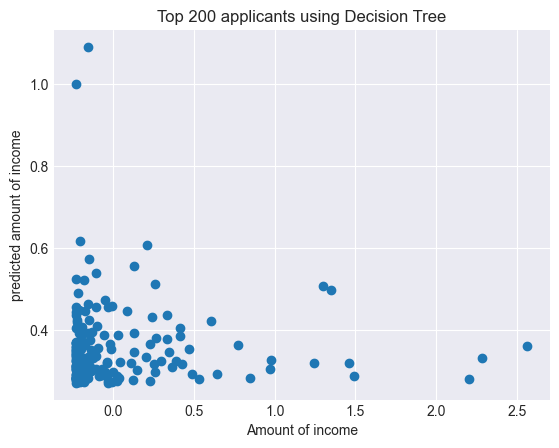

In [298]:
# Make predictions using the trained model (Linear Regression)
# Replace model.predict with the name of your trained model's predict function
applicants_who_will_cause_damage["profit_am"] = lin_reg.predict(applicants_who_will_cause_damage)

# Select the top 200 applicants with the highest predicted profit_am
top_200 = applicants_who_will_cause_damage.nlargest(200, "profit_am")

# Plot the selected applicants on a scatter plot
plt.scatter(top_200["income_am"], top_200["profit_am"])
plt.title("Top 200 applicants using Decision Tree")
plt.xlabel("Amount of income")
plt.ylabel("predicted amount of income")
plt.show()

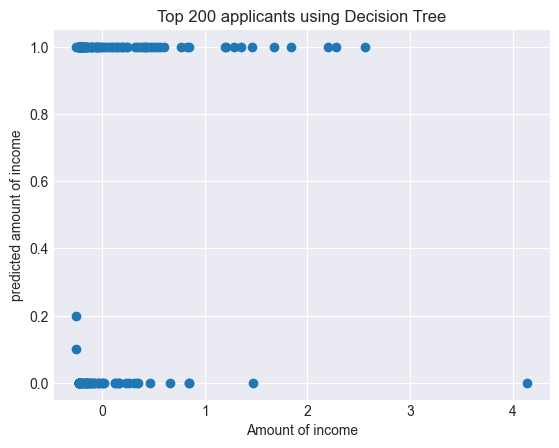

In [299]:
# Make predictions using the trained model (Decision Tree)
# Replace model.predict with the name of your trained model's predict function
applicants_who_will_cause_damage["profit_am"] = dec_tree.predict(applicants_who_will_cause_damage)

# Select the top 200 applicants with the highest predicted profit_am
top_200 = applicants_who_will_cause_damage.nlargest(200, "profit_am")

# Plot the selected applicants on a scatter plot
plt.scatter(top_200["income_am"], top_200["profit_am"])
plt.title("Top 200 applicants using Decision Tree")
plt.xlabel("Amount of income")
plt.ylabel("predicted amount of income")
plt.show()

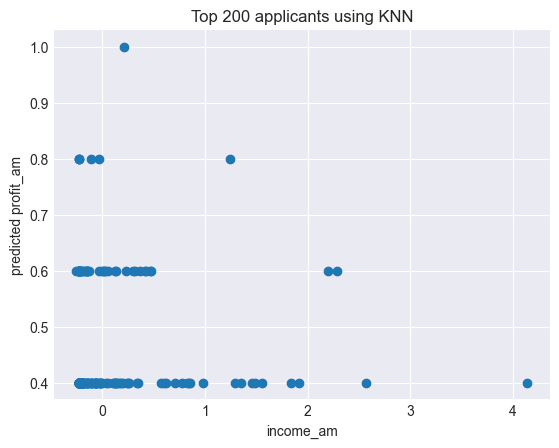

In [295]:
# Make predictions using the trained model (Knearst Neighbors)
# Replace model.predict with the name of your trained model's predict function
applicants_who_will_cause_damage["profit_am"] = knn.predict(applicants_who_will_cause_damage)

# Select the top 200 applicants with the highest predicted profit_am
top_200 = applicants_who_will_cause_damage.nlargest(200, "profit_am")

# Plot the selected applicants on a regular plot
plt.scatter(top_200["income_am"], top_200["profit_am"])
plt.title("Top 200 applicants using KNN")
plt.xlabel("income_am")
plt.ylabel("predicted profit_am")
plt.show()


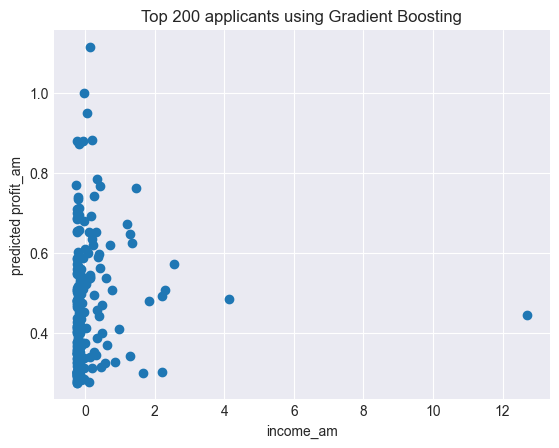

In [296]:
# Make predictions using the trained model (Gradient Boosting)
# Replace model.predict with the name of your trained model's predict function
applicants_who_will_cause_damage["profit_am"] = gb_regressor.predict(applicants_who_will_cause_damage)

# Select the top 200 applicants with the highest predicted profit_am
top_200 = applicants_who_will_cause_damage.nlargest(200, "profit_am")

# Plot the selected applicants on a regular plot
plt.scatter(top_200["income_am"], top_200["profit_am"])
plt.title("Top 200 applicants using Gradient Boosting")
plt.xlabel("income_am")
plt.ylabel("predicted profit_am")
plt.show()

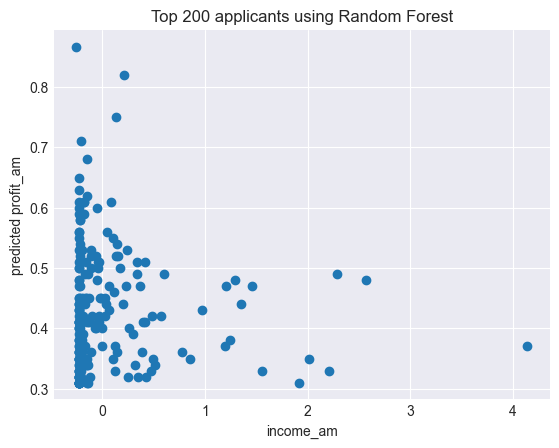

In [297]:
# Make predictions using the trained model (Random Forest)
# Replace model.predict with the name of your trained model's predict function
applicants_who_will_cause_damage["profit_am"] = rnd_forest.predict(applicants_who_will_cause_damage)

# Select the top 200 applicants with the highest predicted profit_am
top_200 = applicants_who_will_cause_damage.nlargest(200, "profit_am")

# Plot the selected applicants on a regular plot
plt.scatter(top_200["income_am"], top_200["profit_am"])
plt.title("Top 200 applicants using Random Forest")
plt.xlabel("income_am")
plt.ylabel("predicted profit_am")
plt.show()